# PyTorch Deep Learning

The goal is to create a neural network for classification which classifies based on 2 input features between 3 output labels - Multi Class Classification

Therefore, we create a dataset from sklearn for classification and use this for train and test data. The dataset is randomly generated, which leads to different results when generated again. This is on purpose to see different behaviour of a model with every execution of the notebook.

We train 3 models with minimal different architectures for which the exact same dataset, amount of epochs, same loss- & optimizer-function and same Learning rate is used. 
This should show already different results based on the architecture and points out that a proper archtiecture to solve a problem is key.



## 01 Create Data-Set for classification

Data-Set `make_classification` taken from `sklearn.datasets` to create sample data.

Creating 1000 samples with 2 features (X) and resulting in one of 3 possible classes in the label (y).



In [1]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X: (1000, 2), y: (1000,), y-samples: [1 2 2 2 1 0 1 1 1 2 2 2 0 2 0 1 1 1 2 2]


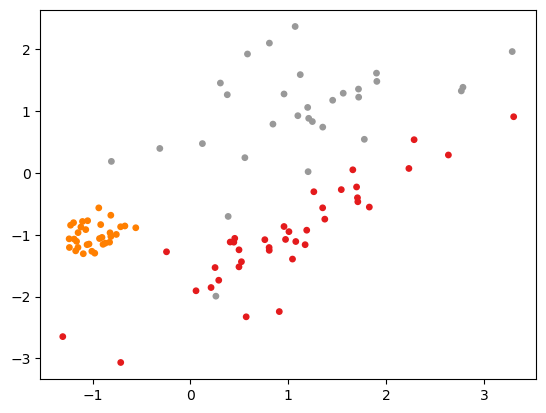

In [2]:
# Create 1000 Samples with 2 features and 3 classes
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_repeated=0, n_classes=3)

# Print the shape of X and y and sample of 20 items of y
print(f"X: {X.shape}, y: {y.shape}, y-samples: {y[:20]}")

# Plot the data to see the distribution
plt.scatter(x=X[:100,0], y=X[:100,1], c=y[:100], marker="o", s=15, edgecolors="face", cmap="Set1")


In [3]:
# MPS Check
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")
else:
    device = torch.device("mps")


In [4]:
# Turn Data into Tensors, so we can use it for our model and put it on device
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

# View the first five samples
X[:5], y[:5]

(tensor([[-1.2398, -1.0655],
         [ 1.9052,  1.4815],
         [ 0.3765,  1.2659],
         [ 0.2601, -1.9931],
         [-0.8217, -0.9677]], device='mps:0'),
 tensor([1., 2., 2., 2., 1.], device='mps:0'))

In [5]:
# Split data into train and test sets by using sklearn function train_test_split
# Using random_state to build reproducible data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 02 Putting the "Deep" into a model

Ok, this model is not very deep, but has more layers then in part 01

This model will classify 2 inputs and will trigger one of 3 output neurons for the classification.

Actually all 3 will be triggered, but each one with a propability.

The model will use 5 hidden units, so the model can be trained on 5 numbers instead of 2

We will use also an activation function after the first layer, to introduce non-linearity.
This will add in our case a ReLU function on top of the linear function.

Mathematically it will look like for the linear function y = W * X + b to add the ReLU => z = ReLU(y) and ReLU defined by z = max(0, y)

### 02.01 First Model

**Structure:**
* Input Layer, 1 Hidden Layer, Output Layer
* 2 Input Features
* 5 Hidden Neurons
* 3 Output Features


![Neural-Network](assets/Neural-Network.jpg)


**Class Setup:**
1. Flatten dimensions of tensors - seems relevant for dense networks (each neuron in one layer is connected to each on the next layer - fully connected)
2. Input Layer as Linear layer with 2 inputs and 5 outputs
3. Activation Function ReLU (returns input if positive, otherwise 0)
4. Output Layer as Linear layer with 5 inputs and 1 output
5. Activation Function ReLU (returns input if positive, otherwise 0)


In [6]:
# Construct a classifcation model
class SampleClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Using Linear Layers for setup
        # A Layer Stack is a convinient way to stack the layers, so it doesn't need to be done in the forward function one by one
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2, out_features=5), # Layer 1 takes the 2 input features (X) and use 5 outputs for the hidden layer - hidden units or neurons
            nn.ReLU(), # Activation function
            nn.Linear(in_features=5, out_features=3), # takes in the 5 from before and outputs 3
            nn.ReLU() # Activation function
        )
    
    # Forward method
    def forward(self, x):
        # Return the Layer Stack
        return self.layer_stack(x)

# Now build the instance and put it on the device
model = SampleClassificationModel().to(device)

# Show the model
model

SampleClassificationModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2, out_features=5, bias=True)
    (2): ReLU()
    (3): Linear(in_features=5, out_features=3, bias=True)
    (4): ReLU()
  )
)

In [7]:
## Prepare some functions

# Calculate accuracy (a classification metric)
def accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)

    correct = torch.eq(predicted, labels).sum().item()
    acc = (correct / len(labels)) * 100 
    return acc

# Draw the curves
def draw_curve(epoch_count, train_loss_values, test_loss_values, train_acc=None, test_acc=None):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    
    axs[0].plot(epoch_count, train_loss_values, label='Train Loss', color='blue')
    axs[0].plot(epoch_count, test_loss_values, label='Validation Loss', color='orange')
    axs[0].set_title('Training and Validation Loss')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epoch_count, train_acc, label='Train Accuracy', color='green')
    axs[1].plot(epoch_count, test_acc, label='Validation Accuracy', color='red')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].legend()
    axs[1].grid(True)

# Training Step
def train(model, X_train, y_train, loss_fn, optimizer):
    model.train() 
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, y_pred

# Validation Step
def validate(model, X_test, y_test, loss_fn):
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
    return test_loss, test_pred


# Define a function to train and test from above
def train_test(model, train_data, test_data, loss_fn, optimizer, epochs):

    X_train, y_train = train_data
    X_test, y_test = test_data

    train_loss_values = []
    test_loss_values = []
    train_accurancy = []
    test_accurancy = []
    epoch_count = []

    pbar = trange(epochs,desc="Training")
    plt.pause(0.5)

    for epoch in pbar:
        # Train
        train_loss, train_pred = train(model, X_train, y_train, loss_fn, optimizer)
        # Validation
        test_loss, test_pred = validate(model, X_test, y_test, loss_fn)

        # Output
        if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(train_loss.to("cpu").detach().numpy())
            test_loss_values.append(test_loss.to("cpu").detach().numpy())
            train_accurancy.append(accuracy(train_pred, y_train))
            test_accurancy.append(accuracy(test_pred, y_test))
            #print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
            pbar.set_description_str(desc=f'Training - Epoch: {epoch} - Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f}')
    
    epoch_count.append(epoch)
    train_loss_values.append(train_loss.to("cpu").detach().numpy())
    test_loss_values.append(test_loss.to("cpu").detach().numpy())
    train_accurancy.append(accuracy(train_pred, y_train))
    test_accurancy.append(accuracy(test_pred, y_test))
    pbar.set_description_str(desc=f'Training - Epoch: {epoch} - Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f}')

    return epoch_count, train_loss_values, test_loss_values, train_accurancy, test_accurancy

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

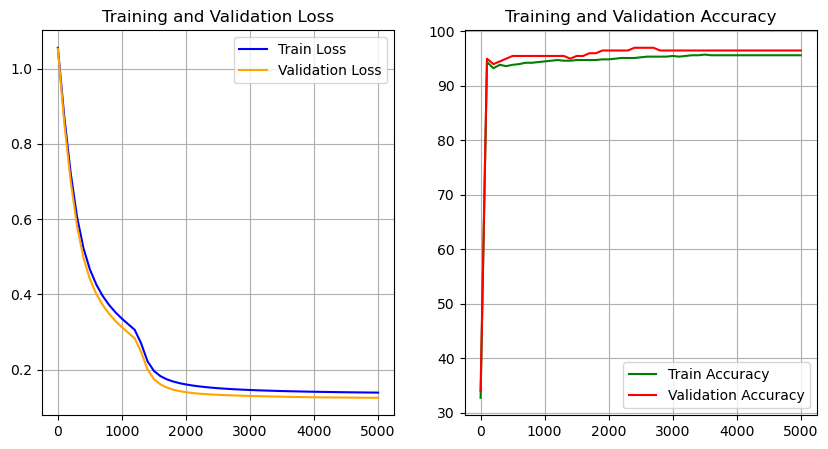

In [8]:
# Define the amount of Epochs
epochs = 5000

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer with a learning rate of 0.001

stats=train_test(model=model, train_data=(X_train, y_train), test_data=(X_test, y_test),loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

draw_curve(*stats)


### 02.02 Second Model

Let's try to improve the model by adding 2 more hidden layers.

* Input Layer: 2 Input Features
* Hidden Layer 1: 5 neurons
* Hidden Layer 2: 5 neurons
* Hidden Layer 3: 5 neurons
* Output Layer: 3 Labels

After each linear layer a ReLU activation function


In [9]:
# Construct a classifcation model
class SampleClassificationModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Using Linear Layers for setup
        # A Layer Stack is a convinient way to stack the layers, so it doesn't need to be done in the forward function one by one
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2, out_features=5), # Layer 1 takes the 2 input features (X) and use 5 outputs for the hidden layer - hidden units or neurons
            nn.ReLU(), # Activation function
            nn.Linear(in_features=5, out_features=5), # takes in the 5 from before and outputs 5
            nn.ReLU(), # Activation function
            nn.Linear(in_features=5, out_features=5), # takes in the 5 from before and outputs 5
            nn.ReLU(), # Activation function
            nn.Linear(in_features=5, out_features=3), # takes in the 5 from before and outputs 3
            nn.ReLU() # Activation function
        )
    
    # Forward method
    def forward(self, x):
        # Return the Layer Stack
        return self.layer_stack(x)

# Now build the instance and put it on the device
model_2 = SampleClassificationModelV2().to(device)

# Show the model
model_2

SampleClassificationModelV2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2, out_features=5, bias=True)
    (2): ReLU()
    (3): Linear(in_features=5, out_features=5, bias=True)
    (4): ReLU()
    (5): Linear(in_features=5, out_features=5, bias=True)
    (6): ReLU()
    (7): Linear(in_features=5, out_features=3, bias=True)
    (8): ReLU()
  )
)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

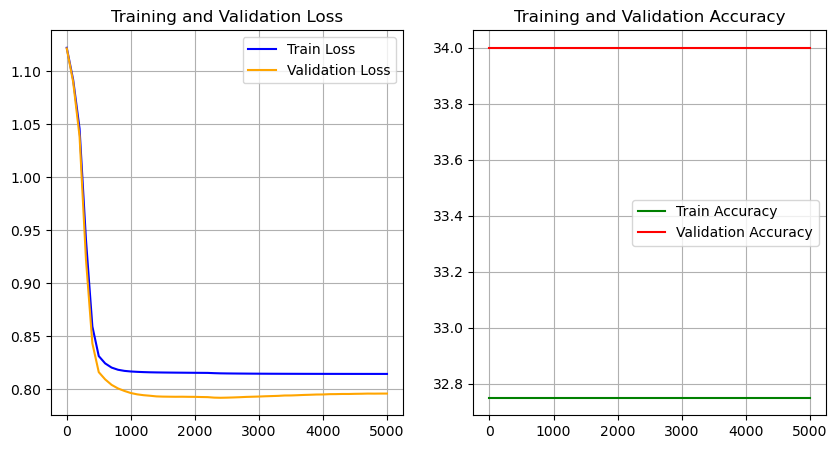

In [10]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)  # Using Adam optimizer with a learning rate of 0.001

stats_2=train_test(model=model_2, train_data=(X_train, y_train), test_data=(X_test, y_test),loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)
draw_curve(*stats_2)

    

### 02.02 Third Model

Let's try to improve the model by adding sticking to 1 hidden layer, but having more neu

* Input Layer: 2 Input Features
* Hidden Layer 1: 10 neurons
* Output Layer: 3 Labels

After each linear layer a ReLU activation function


In [11]:
# Construct a classifcation model
class SampleClassificationModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(), # Activation function
            nn.Linear(in_features=10, out_features=3),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

# Now build the instance and put it on the device
model_3 = SampleClassificationModelV3().to(device)

# Show the model
model_3

SampleClassificationModelV3(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=3, bias=True)
    (4): ReLU()
  )
)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

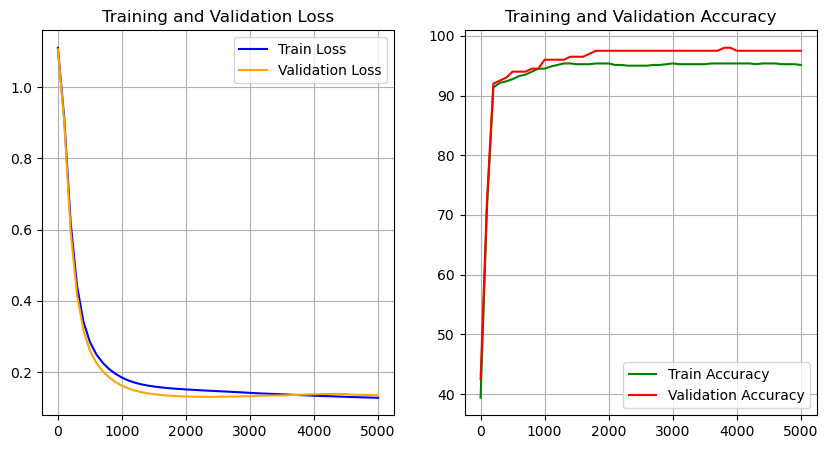

In [12]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

stats_3=train_test(model=model_3, train_data=(X_train, y_train), test_data=(X_test, y_test),loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)
draw_curve(*stats_3)
